# 실습 7. torch.nn 라이브러리를 사용하여 이전 실습 다시 해결하기  
  
이전 실습에서는 신경망의 구조를 직접 설계하고, 경사하강법을 코딩을 통해 직접 구현하여 점을 그 점이 속하는 소용돌이로 분류하는 머신러닝 문제를 해결해보았다. 이번 실습의 궁극적인 목표는 실습 3-2과 동일하게, 점을 분류하는 문제를 해결하는 것이다. 하지만 이번에는 머신러닝을 구현하는 데 있어서 특화되어있는 라이브러리, torch.nn의 사용법을 배우고 이를 활용하여 문제를 더 간편하게 해결하보자. 이에 본 실습에서는 실습 3-2에서 다루었던 내용을 거의 생략하였으니, 관련 내용이 기억이 나지 않는다면 적절히 복습하도록 하자.

## Step 1. 필요한 라이브러리 import 하기, 데이터 가져오기  
  
이번 실습을 진행하는 데 필요한 라이브러리를 import 하고, 데이터를 가져오는 과정이다. 실습 6의 Step 1과 완전히 동일한 과정을 진행하자.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/2024_OUTTA

/content/gdrive/MyDrive/2024_OUTTA


In [4]:
%ls

nba_draft_measurements.nc          실습2_2_경사하강법을_이용하여_선형_회귀_모델_학습시키기.ipynb
__pycache__/                       실습_3-1_Universal_Approximator.ipynb
toydata.py                         실습_3_2_dot_classification.ipynb
실습1_데이터셋_가지고놀기.ipynb    실습_3_3_dot_classification_withNN.ipynb
실습2_1_자동미분_라이브러리.ipynb


In [5]:
# Please Do NOT Modiify this Cell
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import toydata

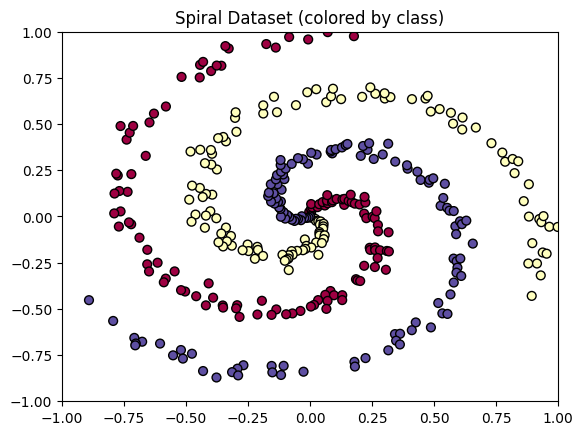

In [6]:
# 사용할 소용돌이 데이터셋 구축
num_tendril = 3 # 데이터에 포함된 소용돌이의 개수 지정.
data = toydata.ToyData(num_classes=num_tendril)

# 데이터셋 분류하기
xtrain, ytrain, xtest, ytest = data.load_data()

# 소용돌이 형태를 좌표평면 위에 나타내기
fig, ax = data.plot_spiraldata()

In [7]:
# xtrain, ytrain의 type() 확인하기
print(type(xtrain))
print(type(ytrain))

# xtrain, ytrain 출력하기
print(f"xtrain: {xtrain} \n")
print(f"ytrain: {ytrain}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
xtrain: [[-0.15836024  0.17402688]
 [ 0.05247907 -0.06563228]
 [ 0.6133928   0.4705818 ]
 [ 0.00509149 -0.16799009]
 [-0.8915931  -0.45283738]
 [-0.11906816  0.3053366 ]
 [ 0.55263     0.04696273]
 [-0.6879619  -0.11482775]
 [-0.51286554 -0.7690438 ]
 [-0.2721483  -0.18260057]
 [-0.09865304  0.2591697 ]
 [ 0.8393181   0.29831517]
 [-0.3758464   0.2542777 ]
 [ 0.61474365  0.5352763 ]
 [-0.52033305 -0.39860278]
 [-0.40902424 -0.36201352]
 [-0.36942783 -0.13969569]
 [ 0.6298477  -0.0225733 ]
 [ 0.28190643 -0.1830714 ]
 [-0.34155625  0.921959  ]
 [ 0.5262489   0.05778347]
 [ 0.00398521  0.04182738]
 [-0.7274264   0.4533704 ]
 [ 0.6044771  -0.0261388 ]
 [-0.11717454 -0.8575782 ]
 [ 0.24044095 -0.1693911 ]
 [-0.5182922   0.75522685]
 [ 0.9411748   0.00178103]
 [-0.4445554   0.15434955]
 [ 0.23805861  0.39616027]
 [-0.03886754 -0.5111294 ]
 [ 0.05436283 -0.03954918]
 [ 0.3239537   0.64601356]
 [ 0.19095173 -0.34573   ]
 [-0.10190741 -0.23974428]

## Step 2. 모델의 학습 정확도를 계산하는 함수 작성하기  
  
실습 3-2와 동일한 함수 accuracy를 작성하자.

In [9]:
def accuracy(predictions, truth):
    """
    하나의 batch에 대한 모델의 예측값과 실제값을 비교하여, 정확도를 계산하는 함수

    매개변수 (Parameters)
    ----------
    predictions : torch.Tensor, shape=(M, D)
        M은 batch를 구성하는 데이터의 개수, D는 분류할 소용돌이의 개수(이번 실습에서는 3으로 사용)
        Step 3에서 정의한 모델의 forward 메서드에서의 출력 인자 그대로가 이 함수에 전달된다고 생각

    truth : torch.Tensor, shape=(M,)
        batch를 구성하는 각각의 데이터(점)가 실제로 어떤 소용돌이에 포함되는지를 0, 1, ..., D-1의 숫자 중 하나로 나타내어 나열한 것
        예를 들어, batch에 3개의 데이터가 들어있고, 각각이 0번, 1번, 1번 소용돌이에 속한다면 truth는 [0, 1, 1]의 배열

    반환 값 (Returns)
    -------
    float형
        해당 batch에 대한 모델의 분류 정확도, 0 이상 1 이하의 실수값
    """
    # 개별 데이터에 대해, predictions에서 구해진 D개의 값 중 가장 큰 값의 인덱스 확인
    # 이 인덱스는 모델은 이 데이터가 어느 소용돌이에 속한다고 판단할지를 의미
    # 이 인덱스, 그리고 해당 데이터의 truth 값이 같은지, 다른지 확인
    predicted_labels = torch.argmax(predictions, axis=1) # 열방향
    correct = (predicted_labels == truth).float()
    accuracy = correct.mean().item() # 0 or 1
    return accuracy


## Step 3. torch.nn 라이브러리로 밀집 신경망 구축하는 방법 익히기  
  
이번 실습에서, 그리고 앞으로의 실습들에서 활용하게 될 라이브러리 torch.nn은 신경망을 구축하고 관리하거나 학습시키는 데 있어 필요로 하는 기본적인 기능들을 미리 만들어놓은 라이브러리이다. 이번 Step 3에서는 밀집 신경망(dense neural network)를 구축하고, 이를 이용하여 각 노드에서의 출력을 계산해보자. 이후의 Step 6에서는 라이브러리에 내장되어있는 optimizer를 활용해보는 기능도 사용해볼 것이다.

우선, 아래 코드를 사용하여 torch.nn 라이브러리에 구축되어있는 클래스인 Linear를 import 해오자.

In [10]:
from torch.nn import Linear

Linear 클래스는 신경망에서의 하나의 밀집층을 구현해놓은 것이다. 객체를 생성할 때는, 입력 데이터와 출력 데이터의 차원을 입력하면 자동으로 가중치(weight)와 편향(bias)를 초기화해준다. 다양한 초기화 방법을 설정할 수 있으니, 필요한 방법이 있으면 라이브러리 링크를 참고하여 적절히 사용해보자. 객체를 생성한 이후, 입력해준 입력 데이터의 차원을 갖는 데이터를 이 층에 통과시켜주면 가중치와 편향을 반영한 출력값을 내어준다. 따라서 실제로 모델을 학습시킬 때, 활성함수 등은 따로 지정하여 구현해주어야 한다.

우선, 클래스의 객체를 하나 생성해보자.

In [12]:
# 입력 데이터의 차원 2, 출력 데이터의 차원 3인 밀집 신경망을 초기화하는 코드
# 해당 밀집 신경망의 구축에 필요한 가중치인 shape-(2, 3) torch 텐서와 편향 shape-(3,) torch 텐서가 자동으로 초기화됨
# 기본적인 가중치 초기화 방법은 균등분포로부터의 랜덤 추출
# 기본적인 편향의 초기화 방법은 상수(0)로 초기화

dense_layer = Linear(2, 3, bias=True) # 사이에 있는 은닉층의 차원을 신경 쓸 필요 X
dense_layer
# 아래 모식도는 bias를 하나의 노트(1)로 생각하고 계산

Linear(in_features=2, out_features=3, bias=True)

아래 그림은 위 코드를 실행했을 때 초기화되는 신경망의 모식도이므로, 참고하자.

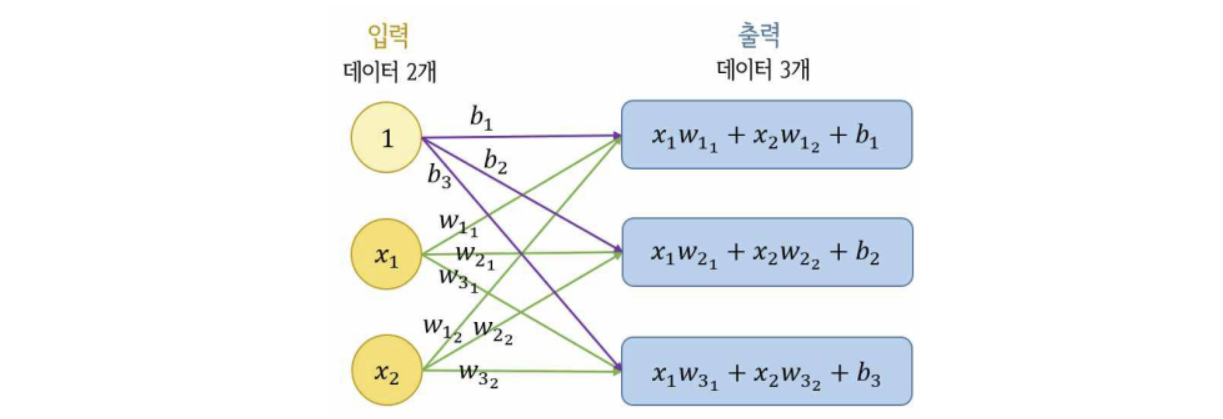


이제 가중치와 편향을 확인해보고, 임의의 데이터에 대한 출력값 계산을 각각 코드로 어떻게 구현하는지 확인해보자. 모식도를 참고하여 아래 코드들의 실행 결과를 예상해본 이후, 직접 실행해보자.

In [13]:
# 생성된 객체 dense_layer의 weight를 출력
# 의도한 shape-(2, 3) 형태의 tensor가 생성되었는지 확인해보자
dense_layer.weight

Parameter containing:
tensor([[ 0.5049, -0.0278],
        [-0.5768,  0.4941],
        [-0.1289,  0.0346]], requires_grad=True)

In [14]:
# 생성된 객체 dense_layer의 bias를 출력
# 의도한 shape-(3,) 형태의 tensor가 생성되었는지 확인해보자
dense_layer.bias

Parameter containing:
tensor([-0.5612, -0.6484,  0.0077], requires_grad=True)

In [15]:
# 층에 포함되는 모든 파라미터(가중치, 편향)이 튜플 형태로 저장된 ‘parameters’
# 이후, 모델을 학습시키는 과정에서 파라미터에 접근하는 것을 용이하게 해준다
for param in dense_layer.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([3, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([3])


이번에는 이 밀집층에 적절한 데이터를 입력시켜, 출력되는 값을 확인해보자. 각각의 차원이 2이고, batch 크기가 4인 test_data를 랜덤하게 생성해보자. 앞서 확인한 가중치와 편향 값으로 모델을 통해 계산되어야 하는 출력값을 예측해보고, 코드의 실행 결과와 일치하는지도 확인해보자.

In [16]:
# 랜덤하게 데이터 생성
test_data = torch.rand(4, 2)
# 생성한 데이터 출력
print(test_data)

# 밀집층에 의한 출력값 계산
# 내부적으로 이루어지는 계산은 test_data @ weight + bias (브로드캐스팅 고려)
# 출력 결과 :  [입력 데이터] (4, 2) x [layer shape] (2 , 3) = (4, 3) 텐서
dense_layer(test_data)

tensor([[0.2563, 0.2084],
        [0.0470, 0.9196],
        [0.6956, 0.5427],
        [0.1037, 0.6218]])


tensor([[-0.4376, -0.6933, -0.0181],
        [-0.5631, -0.2212,  0.0335],
        [-0.2251, -0.7815, -0.0631],
        [-0.5262, -0.4011,  0.0159]], grad_fn=<AddmmBackward0>)

## Step 4. 사용할 활성함수, 손실함수와 모델 파라미터 초기화 방식 import 하기  
  
Step 3에서는 nn 라이브러리를 이용하여 밀집층을 구성하는 방법을 익혔다. 이를 활용하여 본격적인 신경망을 구현하기 이전에, 이전 실습에서 사용했던 활성함수인 ReLU 함수와 모델 파라미터 초기화 방식인 he_normal을 동일하게 사용하자. 이 과정은 이전 실습에 명시되어있다. 손실함수로 사용할, 소프트맥스 함수와 교차 엔트로피 함수가 결합된 F.cross_entropy 함수도 사용하자. 이 과정도 이전 실습에 명시되어있다.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 5. 모델(클래스) 정의하기  
  
이제, nn 라이브러리를 적절히 활용하여 우리의 모델을 클래스의 형태로 코딩해보자. 클래스의 기능은 실습 6에서와 동일하게, 모델 파라미터를 초기화하고, 순전파 과정을 시행하는 것이다. 전반적인 클래스의 구조는 이때까지 살펴본 실습들에서와 유사하다.  
우리가 최종적으로 구현하고자 하는 신경망은 실습 6에서와 마찬가지로, 다음과 같은 근사식을 표현하는 것이다.  
  
$ \mathbf{y_{i}} = F(\{\mathbf{v_i}\}, \{\mathbf{w_i}\}, \{b_i\}; \mathbf{x}) = \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x} \cdot \mathbf{w_i} + b_i) $  
  
__init__ 메서드를 작성할 때 두 개의 밀집층을 생성하고, 이 둘을 이용하여 전체적인 순전파를 구성해보자. 거치게 되는 첫 번째 밀집층은 점의 좌표인 2개의 입력을 받아 사용할 뉴런의 개수만큼의 출력을 내도록 하자. 이를 통해 $\mathbf{x} \cdot \mathbf{w_i} + b_i$의 연산을 구현하자. 이후, 계산된 결과(행렬) 전체에 활성함수인 ReLU 함수 $\varphi$를 취하자. 이어, 뉴런의 개수만큼의 입력을 받아 최종적으로 원하는 결과인 3개(총 소용돌이의 개수)의 출력을 내보내는 두 번째 밀집층을 연결해주면 된다. 두 번째 밀집층의 경우 편향을 두지 않도록 하고, 이 모든 연산을 이어 진행하면 위의 근사식에서의 계산을 구현할 수 있다. 이제 아래 코드를 완성해보자.

In [18]:
class Model(nn.Module):
    def __init__(self, num_neurons, num_classes):
        """
        모델에 포함되는 모든 층을 생성.
        생성한 층들은 클래스의 속성으로 설정한다.

        매개변수 (Parameters)
        ----------
        num_neurons : int형
            은닉층의 크기(은닉층에서 사용하게 될 뉴런의 개수)

        num_classes : int형
            출력층의 크기(점을 분류하게 될 소용돌이의 총 개수)
        """
        super(Model, self).__init__()
        # 밀집층 dense1
        # 점의 좌표, 즉 두 개의 데이터를 입력받아 은닉층 뉴런 개수만큼의 출력
        self.dense1 = nn.Linear(2, num_neurons)
        # 밀집층 dense2
        # 은닉층 뉴런 개수만큼의 데이터를 입력받아 소용돌이의 개수만큼의 출력
        self.dense2 = nn.Linear(num_neurons, num_classes)

        # 가중치 초기화는 He-normal 초기화를 사용
        nn.init.kaiming_normal_(self.dense1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        """
        모델의 순전파를 진행
        데이터를 입력받아 은닉층에서 출력층으로 전달하는 값을 계산

        매개변수 (Parameters)
        ----------
        x : Union[numpy.ndarray, torch.Tensor]형, shape=(M, 2)
            M개의 데이터로 구성된 하나의 batch, 각 데이터(점의 좌표)의 차원은 2

        반환 값 (Returns)
        -------
        torch.Tensor형, shape=(M, num_classes)
            신경망의 은닉층에서 출력층으로 전달하게 될 shape-(M, num_classes)인 행렬
        """
        x = self.dense2(F.relu(self.dense1(x))) # activation function은 relu를 사용하세요.
        return x

    @property
    def parameters(self):
        """
        모델 파라미터들에 대한 getter를 데코레이터를 이용하여 구현
        이전의 실습들에서와 유사한 형태임을 참고

        반환 값 (Returns)
        -------
        Tuple[Tensor, ...]
            모델 파라미터인 dense1과 dense2의 모든 파라미터를 전부 묶은 튜플을 반환
        """
        return tuple(self.dense1.parameters()) + tuple(self.dense2.parameters())

    def load_parameters(self, w1, b1, w2):
        """
        모델 파라미터들을 외부에서 불러와 설정하는 함수
        """
        self.dense1.weight.data = w1
        self.dense1.bias.data = b1
        self.dense2.weight.data = w2


## Step 6. 모델 학습시키기  
  
이제 모델을 학습시켜보자. 우선, Step 5에서 구현한 클래스의 객체를 생성하자. 초기화 과정에서 뉴런의 개수는 10개, 분류 클래스의 개수는 Step 1에서 지정한 num_tendrils로 지정해주자. 뉴런의 개수는 물론 다른 숫자를 사용해도 좋다.

In [19]:
model = Model(num_neurons = 15, num_classes=3)

이번에는 경사하강법을 직접 코딩하여 구현하는 대신, MyNN 라이브러리에서 지원하는 확률적 경사하강법(SGD, Stochastic Gradient Descent)라는 optimizer를 사용해볼 것이다. SGD는 그 이름으로부터 짐작해볼 수 있듯, 경사하강법의 한 종류이다. 이때까지 우리가 사용했던 경사하강법은 학습용 데이터셋 전체에 대해 손실함수를 계산하여 기울기를 검토한 방법이었다. 이 방법은 데이터의 개수가 많아짐에 따라 계산량이 늘어나 학습에 걸리는 시간이 길어진다는 문제가 있고, 이를 해결하기 위해 한 번에 데이터 한 개를 랜덤으로 선택하여, 이에 대한 손실함수를 계산하고 매번 모델 파라미터를 갱신해주는 방법이 바로 SGD이다. optimizer로 SGD를 사용하면, 학습용 데이터셋을 이루는 데이터 각각에 대해 한 번씩 갱신을 진행하고, 모든 데이터에 대한 갱신이 완료되면 데이터들의 순서를 바꾸어 갱신을 진행하는 것을 반복하게 된다.  
  
아래는 SGD optimizer의 클래스를 import하고, 객체를 생성하는 코드이다. 객체 생성 과정에서 학습률은 0.1로 초기화하였다.

In [21]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters, lr=0.1)

학습에 사용될 batch_size는 50으로 설정하자. 이 값과 학습률 등의 하이퍼파라미터는 적절히 다른 값을 사용해보아도 좋다.

In [22]:
batch_size = 50

이제, 아래의 주석을 천천히 읽으며 학습을 진행시키는 코드를 완성해보자. 실습 6에서와 마찬가지로, batch를 구성할 때 우리의 학습 데이터셋을 순서대로 묶지 않고, 한 번 무작위하게 순서를 바꾸어준 후 묶어주어야 학습이 잘 진행된다. 이번에는 nn 라이브러리를 사용하기에 우리가 직접 구현해주어야 하는 부분이 줄어든 것을 확인할 수 있을 것이다.

In [23]:
# loss 값 저장
loss_values = []
acc_values = []
# 학습률 결정
for epoch_cnt in range(1000):
    # 한 번의 epoch가 반복될 때마다 시행하는 코드

    # 학습용 데이터셋을 무작위로 재배열하기
    # `idxs`를 무작위로 재배열하여 데이터셋의 인덱스를 어떻게 재배열할지 결정
    idxs = np.arange(len(xtrain))
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(xtrain) // batch_size):
        # (총 학습용 데이터셋 개수)를 (batch 크기)로 나눈 몫만큼 반복하며 시행

        # 학습용 데이터셋의 새로운 인덱스를 슬라이싱하여 그 배열을 batch_indices에 저장
        # 어느 범위까지 잘라야 할지 생각해보기
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt+1)*batch_size]

        # 학습에 사용할 batch를 추출하기 위해, 윗 단계에서 저장한 batch_indices 위치의 데이터들을 모아 batch와 truth를 생성
        batch = xtrain[batch_indices]
        truth = ytrain[batch_indices]

        # numpy 배열을 torch 텐서로 변환
        batch = torch.tensor(batch)
        truth = torch.tensor(truth)

        # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기
        prediction = model(batch)

        # 출력층의 활성함수와 결합된 손실함수 값 구하기, cross_entropy 함수 활용
        loss = F.cross_entropy(prediction, truth)

        # 기울기 초기화; model.zero_grad() 대신 optimizer 사용
        # optimizer 안에 model parameter 정보 존재
        optimizer.zero_grad()

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss.backward()

        # optimizer를 이용하여 경사하강의 한 스텝 진행
        optimizer.step()

        # 정확도 계산, acc라는 이름으로 저장
        acc = accuracy(prediction, truth)

    loss_values.append(loss.detach().clone().numpy())
    acc_values.append(acc)
    print(f"Epoch {epoch_cnt+1}----------------------------")
    print(f"loss: {loss.item():.6f}")
    print(f"acc: {acc:.6f}")

Epoch 1----------------------------
loss: 1.212331
acc: 0.260000
Epoch 2----------------------------
loss: 1.112825
acc: 0.280000
Epoch 3----------------------------
loss: 1.102410
acc: 0.300000
Epoch 4----------------------------
loss: 1.088272
acc: 0.380000
Epoch 5----------------------------
loss: 1.072788
acc: 0.280000
Epoch 6----------------------------
loss: 1.082878
acc: 0.280000
Epoch 7----------------------------
loss: 1.019804
acc: 0.460000
Epoch 8----------------------------
loss: 1.040316
acc: 0.380000
Epoch 9----------------------------
loss: 0.986094
acc: 0.420000
Epoch 10----------------------------
loss: 0.980851
acc: 0.440000
Epoch 11----------------------------
loss: 0.993991
acc: 0.440000
Epoch 12----------------------------
loss: 1.056454
acc: 0.280000
Epoch 13----------------------------
loss: 1.029666
acc: 0.320000
Epoch 14----------------------------
loss: 0.995638
acc: 0.380000
Epoch 15----------------------------
loss: 1.004017
acc: 0.380000
Epoch 16-----------

학습을 진행하며 손실함수 값과 분류 정확도 값을 그래프로 나타내자.

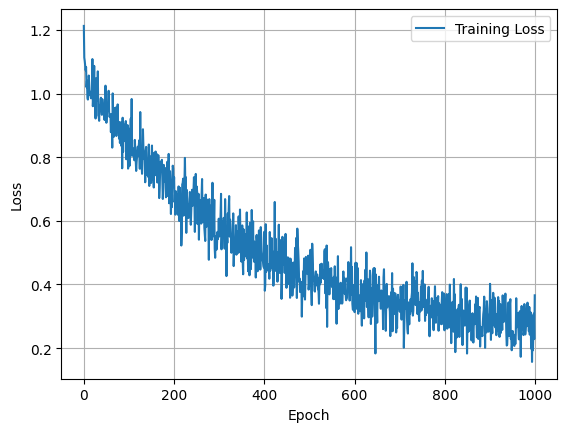

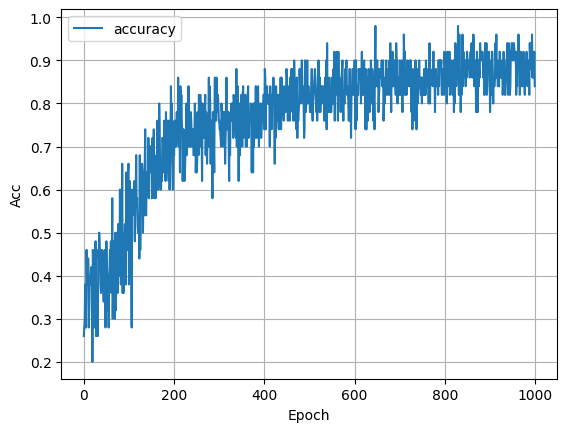

In [24]:
# Plotting loss values
plt.figure()
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(acc_values, label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.grid()
plt.show()

코드를 잘 작성하였다면, 실습 6에서와 마찬가지로 손실함수 값은 감소하고 분류 정확도 값은 증가하는 양상이 확인될 것이다. 정확도를 보며 학습이 잘 이루어졌는지 판단해보자. 추가적으로, 실습 6의 마지막 부분에서 학습된 모델이 점을 분류하는 경계를 색으로 시각화한 그림을 그리는 아래의 코드 또한 그대로 실행해보자. 소용돌이가 잘 분류된다면, 우리는 실습 6에서 직접 구현하던 신경망 학습을 nn 라이브러리를 활용하여 성공적으로 마친 것이다.

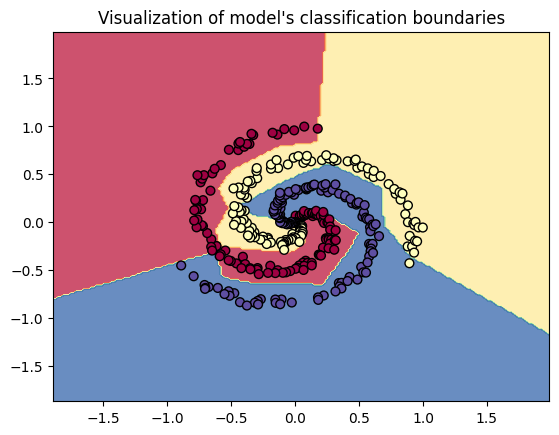

In [25]:
def dummy_function(x):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    return F.softmax(model(x), dim=1).detach().numpy()

fig, ax = data.visualize_model(dummy_function, entropy=False);

## 배운 내용 되돌아보기  
  
이번 실습에서는 이전 실습에서의 문제를 nn 라이브러리를 활용하여 다시 한번 해결해 보았다. nn 라이브러리는 앞으로의 실습에서도 활용될 예정이며, 딥러닝을 위해 개발된 다른 라이브러리 사용에 있어서도 도움을 줄 수 있으니 이번 실습에서 배운 라이브러리의 기능들을 잘 기억해두자. 다음 절로 넘어가기 전에, 배운 내용들을 한 번씩 되짚어보자.  
  
- nn 라이브러리의 Linear 클래스를 사용하여, 원하는 크기의 입력으로부터 원하는 크기의 출력을 만들어낼 수 있는 밀집층을 생성하는 방법을 배웠다.
- 밀집층을 생성할 때, 가중치와 편향의 초기화 방법 등을 선택하는 방법을 배웠다.
- 생성한 밀집층에 적절한 크기의 입력 데이터를 넣어, 그로부터 계산되어 출력되는 데이터를 계산해보았다.
- nn 라이브러리의 SGD 클래스를 사용하여, 직접 지정한 학습률을 이용하여 확률적 경사하강법(SGD, Stochastic Gradient Descent)을 시행하는 optimizer 객체를 생성하였다.
- 손실함수에 대해 역전파를 진행한 이후, 생성한 optimizer 객체를 이용하여 모델 파라미터를 갱신해보았다.
- 이러한 과정들을 적절히 활용하여 점이 속하는 소용돌이를 분류하는 문제를 해결하는 신경망을 학습시켰고, 그 결과 분류가 잘 일어나는 것을 확인하였다.